In this notebook four models trained on different variations of the data are combined.

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import math
import statistics
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, normalize
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib
import warnings
from scipy.signal import savgol_filter, find_peaks, correlate
from sklearn.decomposition import PCA
import scipy.fftpack as FFT
from sklearn.utils import shuffle
import joblib
import scipy.stats as stats
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = [12,5]

In [2]:
def sampling_freq(df):
    start = df['time'].iloc[0]
    sum_samples = 0
    index = 0
    while  (start + pd.to_timedelta(1, unit='s')) < df['time'].iloc[-1]:
        end =  start + pd.to_timedelta(1, unit='s')
        sum_samples += df[(df['time'] >= start) & (df['time'] < end)].shape[0]
        start += pd.to_timedelta(1, unit='s')
        index += 1
    return sum_samples/index

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

def convert_to_datetime(x):
    dt = datetime.fromtimestamp(x // 1000000000)
    s = dt.strftime('%Y-%m-%d %H:%M:%S')
    s += '.' + str(int(x % 1000000000)).zfill(9)
    return s

def heatmap(cm, labels):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize = (10,7))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    ax = sn.heatmap(df_cm, annot=True)

    plt.show(ax)
    
def preprocess(data, activity, drop_interval_begin = 3, drop_interval_end = 3):
    #convert nanoseconds to date 
    data['time'] = data['time'].apply(convert_to_datetime) 
    data['time'] = pd.to_datetime(data['time'])

#convert to same data type
    for i in range(1, 4): 
        data[column_names_org[i]] = data[column_names_org[i]].apply(convert_to_float)
    
#drop rows with NaN values 
    data.dropna(axis=0, how='any', inplace=True) #TODO: invullen met mean, mod of median / interpolatie

#drop duplicates 
    data.drop_duplicates(subset=None, keep='first', inplace = True)
    
    #drop first and last 3 sec
    indexFirst = data[ (data['time'].iloc[0]+ pd.to_timedelta(drop_interval_begin, unit='s')) > data['time'] ].index
    data.drop(indexFirst , inplace=True)
    indexLast = data[ (data['time'].iloc[-1]- pd.to_timedelta(drop_interval_end, unit='s')) < data['time'] ].index
    data.drop(indexLast , inplace=True)
    
    #add activity label
    data['activity'] = activity
    
    return data

def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]
       
        # Retrieve the most often used label in this segment
        label = stats.mode(df['activity'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames)#.reshape(-1, frame_size, N_FEATURES)
    print("NEW:",frames)
    labels = np.asarray(labels)

    return frames, labels

def windows(data, size, overlap):
    start = 0
    while start < data.count():
        yield start, start + size
        if(overlap):
            start += (size * overlap)
        else:
            start += size 
        
def segment_signal(data,window_size, overlap, l=True):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in windows(data["time"], window_size, overlap):
        start = int(start)
        end = int(end)
        x = data["x"][start:end]
        y = data["y"][start:end]
        z = data["z"][start:end]
        if(len(data["time"][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            if l:
                labels = np.append(labels,stats.mode(data["activity"][start:end])[0][0])
    return segments, labels

In [5]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from keras.regularizers import l1
tf.compat.v1.enable_eager_execution()

Using TensorFlow backend.


## Load models

In [24]:
model1 = tf.keras.models.load_model('left_backward_left_left')
model2 = tf.keras.models.load_model('left_forward_left_right')
model3 = tf.keras.models.load_model('right_backward_right_left')
model4 = tf.keras.models.load_model('right_forward_right_right')
model = tf.keras.models.load_model('one_model_1')

## Validation data

In [8]:
validation_data_rf1 = pd.read_csv(r"..\data\validation_data\jump_fastside_right_forward_val.csv", sep=';', header=0, skipinitialspace=True)
validation_data_rf2 = pd.read_csv(r"..\data\validation_data\jumpslow+crossover_right_forward_val.csv", sep=';', header=0, skipinitialspace=True)

validation_data_rb1 = pd.read_csv(r"..\data\validation_data\fastside_right_backward_val.csv", sep=';', header=0, skipinitialspace=True)
validation_data_rb2 = pd.read_csv(r"..\data\validation_data\jumpslow+crossover_right_backward_val.csv", sep=';', header=0, skipinitialspace=True)

validation_data_lf1 = pd.read_csv(r"..\data\validation_data\jump_fast+side_left_forward_val.csv", sep=';', header=0, skipinitialspace=True)
validation_data_lf2 = pd.read_csv(r"..\data\validation_data\crossover_left_forward_val.csv", sep=';', header=0, skipinitialspace=True)
validation_data_lf3 = pd.read_csv(r"..\data\validation_data\jump_slow_left_forward_val.csv", sep=';', header=0, skipinitialspace=True)

validation_data_lb1 = pd.read_csv(r"..\data\validation_data\jump_fast+side_left_backward_val.csv", sep=';', header=0, skipinitialspace=True)
validation_data_lb2 = pd.read_csv(r"..\data\validation_data\jump_slow+crossover_left_backward_val.csv", sep=';', header=0, skipinitialspace=True)


#180 MET SPRONG
'''    
validation_data9 = pd.read_csv(r"..\data\validation_data\backward_180_right_right_val.csv", sep=';', header=0, skipinitialspace=True)
validation_data10 = pd.read_csv(r"..\data\validation_data\backward_180_right_left_val.csv", sep=';', header=0, skipinitialspace=True)
validation_data11 = pd.read_csv(r"..\data\validation_data\backward_180_left_right_val.csv", sep=';', header=0, skipinitialspace=True)
validation_data12 = pd.read_csv(r"..\data\validation_data\backward_180_left_left_val.csv", sep=';', header=0, skipinitialspace=True)

validation_data13 = pd.read_csv(r"..\data\validation_data\forward_180_right_right_val.csv", sep=';', header=0, skipinitialspace=True)
validation_data14 = pd.read_csv(r"..\data\validation_data\forward_180_right_left_val.csv", sep=';', header=0, skipinitialspace=True)
validation_data15 = pd.read_csv(r"..\data\validation_data\forward_180_left_left_val.csv", sep=';', header=0, skipinitialspace=True)
validation_data16 = pd.read_csv(r"..\data\validation_data\forward_180_left_right_val.csv", sep=';', header=0, skipinitialspace=True)
''' 

#180 ZONDER SPRONG
  
validation_data9 = pd.read_csv(r"..\data\validation_data\180_zonder_sprong\backward_180_right_right_val2.csv", sep=';', header=0, skipinitialspace=True)
validation_data10 = pd.read_csv(r"..\data\validation_data\180_zonder_sprong\backward_180_right_left_val2.csv", sep=';', header=0, skipinitialspace=True)
validation_data11 = pd.read_csv(r"..\data\validation_data\180_zonder_sprong\backward_180_left_right_val2.csv", sep=';', header=0, skipinitialspace=True)
validation_data12 = pd.read_csv(r"..\data\validation_data\180_zonder_sprong\backward_180_left_left_val2.csv", sep=';', header=0, skipinitialspace=True)

validation_data13 = pd.read_csv(r"..\data\validation_data\180_zonder_sprong\forward_180_right_right_val2.csv", sep=';', header=0, skipinitialspace=True)
validation_data14 = pd.read_csv(r"..\data\validation_data\180_zonder_sprong\forward_180_right_left_val2.csv", sep=';', header=0, skipinitialspace=True)
validation_data15 = pd.read_csv(r"..\data\validation_data\180_zonder_sprong\forward_180_left_left_val2.csv", sep=';', header=0, skipinitialspace=True)
validation_data16 = pd.read_csv(r"..\data\validation_data\180_zonder_sprong\forward_180_left_right_val2.csv", sep=';', header=0, skipinitialspace=True)



In [9]:
val_data1 = pd.DataFrame()

In [10]:

val_data1 = val_data1.append(preprocess(validation_data2[(validation_data2["time"] > 54121300000000) & (validation_data2["time"] < 54124300000000) ],"jump_slow",0, 0))

val_data1= val_data1.append(preprocess(validation_data2[ (validation_data2["time"] > 54124300000000) & (validation_data2["time"] < 54126300000000) ], "jump_fast", 0, 0))

val_data1= val_data1.append(preprocess(validation_data2[(validation_data2["time"] > 54126300000000) & (validation_data2["time"] < 54127700000000) ], "forward_180", 0, 0))

val_data1= val_data1.append(preprocess(validation_data2[ (validation_data2["time"] > 54127700000000) & (validation_data2["time"] < 54130600000000) ], "jump_slow", 0, 0))

val_data1= val_data1.append(preprocess(validation_data2[(validation_data2["time"] > 54130600000000) & (validation_data2["time"] < 54132800000000) ], "jump_fast", 0, 0))

val_data1= val_data1.append(preprocess(validation_data2[(validation_data2["time"] > 54132800000000) & (validation_data2["time"] < 54135600000000) ], "jump_slow", 0, 0))

val_data1= val_data1.append(preprocess(validation_data2[(validation_data2["time"] > 54135600000000) & (validation_data2["time"] < 54137500000000) ], "backward_180", 0, 0))

val_data1= val_data1.append(preprocess(validation_data2[ (validation_data2["time"] > 54137500000000) ], "jump_slow", 0, 1.5))

In [12]:
 
val_data1 = val_data1.append(preprocess(validation_data4[(validation_data4["time"] >= 54437200000000) & (validation_data4["time"] < 54439000000000) ],"jump_fast",0, 0))
val_data1 = val_data1.append(preprocess(validation_data4[(validation_data4["time"] >= 54439000000000) & (validation_data4["time"] < 54440800000000) ],"side_swing",0, 0))
val_data1 = val_data1.append(preprocess(validation_data4[(validation_data4["time"] >= 54440800000000) & (validation_data4["time"] < 54443600000000) ],"jump_slow",0, 0))
val_data1 = val_data1.append(preprocess(validation_data4[(validation_data4["time"] >= 54443600000000) & (validation_data4["time"] < 54445000000000) ],"cross_over",0, 0))
val_data1 = val_data1.append(preprocess(validation_data4[(validation_data4["time"] >= 54445000000000) & (validation_data4["time"] < 54447700000000) ],"jump_slow",0, 0))
#val_data1 = val_data1.append(preprocess(validation_data4[(validation_data4["time"] >= 54447700000000) & (validation_data4["time"] < 54449700000000) ],"forward_180",0, 0))
val_data1 = val_data1.append(preprocess(validation_data4[(validation_data4["time"] >= 54449700000000) & (validation_data4["time"] < 54451500000000) ],"jump_fast",0, 0))


In [13]:

val_data1 = val_data1.append(preprocess(validation_data5[(validation_data5["time"] >= 3066050000000) & (validation_data5["time"] < 3080310000000) ],"jump_slow",0, 0))
val_data1 = val_data1.append(preprocess(validation_data5[(validation_data5["time"] >= 3080310000000) & (validation_data5["time"] < 3081530000000) ],"forward_180",0, 0))
val_data1 = val_data1.append(preprocess(validation_data5[(validation_data5["time"] >= 3081530000000) & (validation_data5["time"] < 3086510000000) ],"jump_fast",0, 0))
val_data1 = val_data1.append(preprocess(validation_data5[(validation_data5["time"] >= 3086510000000) & (validation_data5["time"] < 3087880000000) ],"backward_180",0, 0))
val_data1 = val_data1.append(preprocess(validation_data5[(validation_data5["time"] >= 3087880000000) & (validation_data5["time"] < 3092260000000) ],"jump_slow",0, 0))
val_data1 = val_data1.append(preprocess(validation_data5[(validation_data5["time"] >= 3092260000000) & (validation_data5["time"] < 3096320000000) ],"cross_over",0, 0))
val_data1 = val_data1.append(preprocess(validation_data5[(validation_data5["time"] >= 3096320000000) & (validation_data5["time"] < 3099910000000) ],"jump_slow",0, 0))
val_data1 = val_data1.append(preprocess(validation_data5[(validation_data5["time"] >= 3099910000000) & (validation_data5["time"] < 3116670000000) ],"side_swing",0, 0))
 

In [14]:

val_data1 = val_data1.append(preprocess(validation_data6[(validation_data6["time"] >= 3477790000000) & (validation_data6["time"] < 3491360000000) ],"jump_slow",0, 0))
val_data1 = val_data1.append(preprocess(validation_data6[(validation_data6["time"] >= 3491360000000) & (validation_data6["time"] < 3492250000000) ],"forward_180",0, 0))
val_data1 = val_data1.append(preprocess(validation_data6[(validation_data6["time"] >= 3492250000000) & (validation_data6["time"] < 3497290000000) ],"jump_fast",0, 0))
val_data1 = val_data1.append(preprocess(validation_data6[(validation_data6["time"] >= 3497290000000) & (validation_data6["time"] < 3497980000000) ],"backward_180",0, 0))
val_data1 = val_data1.append(preprocess(validation_data6[(validation_data6["time"] >= 3497980000000) & (validation_data6["time"] < 3502330000000) ],"jump_slow",0, 0))
val_data1 = val_data1.append(preprocess(validation_data6[(validation_data6["time"] >= 3502330000000) & (validation_data6["time"] < 3506770000000) ],"cross_over",0, 0))
val_data1 = val_data1.append(preprocess(validation_data6[(validation_data6["time"] >= 3506770000000) & (validation_data6["time"] < 3511270000000) ],"jump_slow",0, 0))
val_data1 = val_data1.append(preprocess(validation_data6[(validation_data6["time"] >= 3511270000000) & (validation_data6["time"] < 3521260000000) ],"side_swing",0, 0))


In [15]:

val_data1 = val_data1.append(preprocess(validation_data7[(validation_data7["time"] >= 3404050000000) & (validation_data7["time"] < 3409330000000) ],"jump_fast",0, 0))
val_data1 = val_data1.append(preprocess(validation_data7[(validation_data7["time"] >= 3409330000000) & (validation_data7["time"] < 3410960000000) ],"forward_180",0, 0))
val_data1 = val_data1.append(preprocess(validation_data7[(validation_data7["time"] >= 3410960000000) & (validation_data7["time"] < 3419410000000) ],"jump_slow",0, 0))


In [16]:

val_data1 = val_data1.append(preprocess(validation_data8[(validation_data8["time"] >= 3706030000000) & (validation_data8["time"] < 3718180000000) ],"jump_slow",0, 0))
val_data1 = val_data1.append(preprocess(validation_data8[(validation_data8["time"] >= 3718180000000) & (validation_data8["time"] < 3723120000000) ],"cross_over",0, 0))
val_data1 = val_data1.append(preprocess(validation_data8[(validation_data8["time"] >= 3723120000000) & (validation_data8["time"] < 3727760000000) ],"jump_fast",0, 0))
val_data1 = val_data1.append(preprocess(validation_data8[(validation_data8["time"] >= 3727760000000) & (validation_data8["time"] < 3728750000000) ],"backward_180",0, 0))
val_data1 = val_data1.append(preprocess(validation_data8[(validation_data8["time"] >= 3728750000000) & (validation_data8["time"] < 3732950000000) ],"jump_slow",0, 0))
val_data1 = val_data1.append(preprocess(validation_data8[(validation_data8["time"] >= 3732950000000) & (validation_data8["time"] < 3733980000000) ],"forward_180",0, 0))
val_data1 = val_data1.append(preprocess(validation_data8[(validation_data8["time"] >= 3733980000000) & (validation_data8["time"] < 3738270000000) ],"jump_slow",0, 0))
val_data1 = val_data1.append(preprocess(validation_data8[(validation_data8["time"] >= 3738270000000) & (validation_data8["time"] < 3751900000000) ],"side_swing",0, 0))


## Predicting

In [1]:
window=1
f=52

In [62]:
#label activity
le = preprocessing.LabelEncoder()
le.fit(val_data1['activity'])

val_data1['activity'] = le.transform(val_data1['activity'])

label = le.inverse_transform([0,1,2,3,4,5])
label

array(['backward_180', 'cross_over', 'forward_180', 'jump_fast',
       'jump_slow', 'side_swing'], dtype=object)

In [63]:
segments, labels = segment_signal(val_data1, int(f*window), 1, True)
print(labels)

[4. 4. 3. 2. 4. 4. 3. 3. 4. 4. 0. 4. 4. 3. 5. 4. 4. 1. 4. 4. 3. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 3. 3. 3. 3. 0. 4. 4. 4. 1. 1. 4. 4. 4. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 4. 4. 4. 4. 4. 4. 4. 4. 4. 3. 3. 3. 3. 4. 4. 4. 1.
 1. 1. 4. 4. 4. 5. 5. 5. 5. 5. 5. 5. 3. 3. 3. 2. 2. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 1. 1. 1. 1. 3. 3. 3. 4. 4. 4. 2. 4. 4. 4. 5. 5. 5. 5.
 5. 5. 5. 5. 5.]


In [64]:
#4 models with the same framesize
y_1 = model1.predict(segments)
y_2 = model2.predict(segments)
y_3 = model3.predict(segments)
y_4 = model4.predict(segments)

In [65]:
yhats = [y_1, y_2, y_3, y_4] 
# sum across ensembles
summed = np.sum(yhats, axis=0)
# argmax across classes
outcomes = np.argmax(summed, axis=1)
print(outcomes)

[3 4 4 2 3 3 3 3 4 2 2 3 3 2 0 2 2 3 5 4 3 3 4 4 4 4 4 4 4 4 2 3 3 3 3 2 4
 4 1 1 1 2 4 4 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 3 3 3 4 4 2 1 1 1
 2 2 4 4 5 5 5 5 5 5 2 3 2 2 2 3 2 2 2 4 0 4 4 4 0 2 4 4 3 1 1 3 3 3 3 2 2
 2 0 0 2 0 5 5 1 1 5 5 5 5 5]


<IPython.core.display.Javascript object>


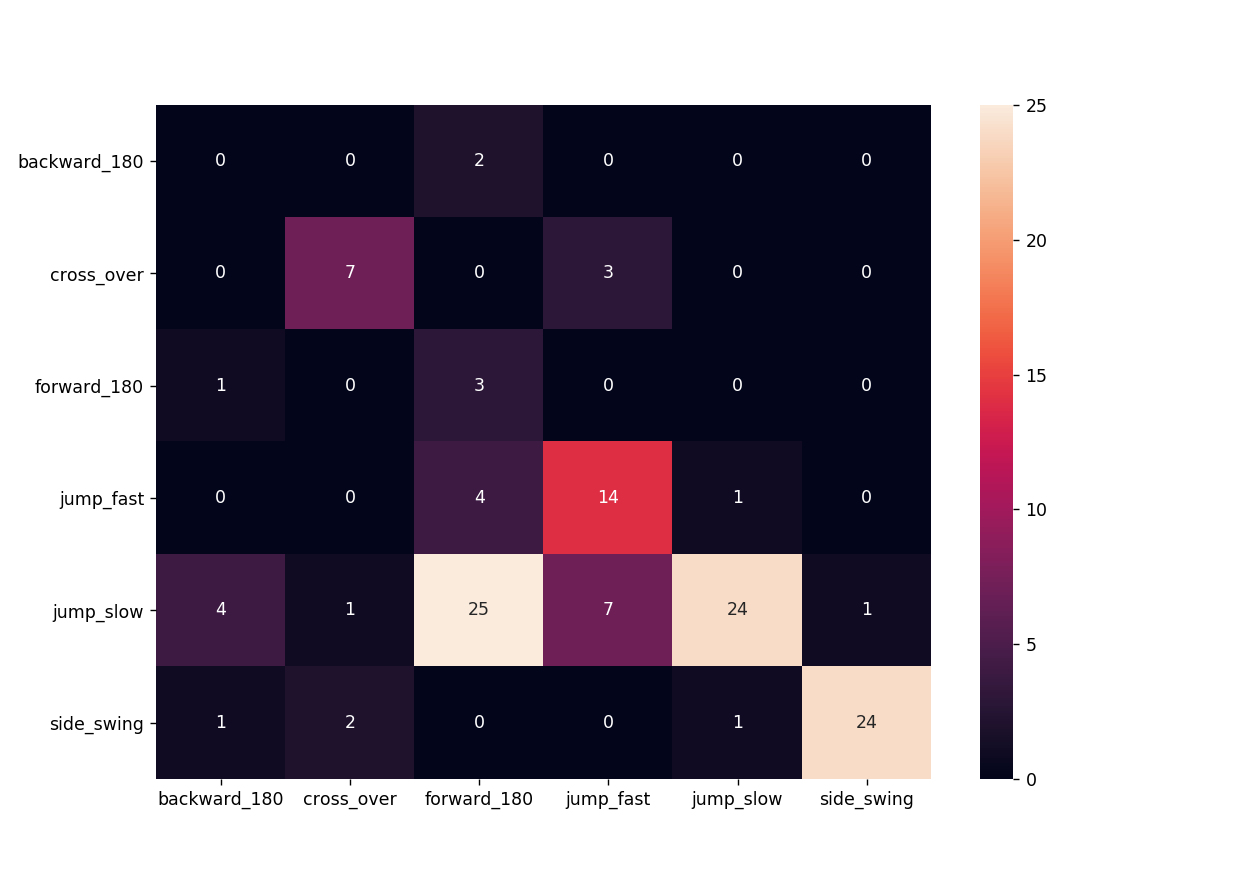

In [67]:
mat = confusion_matrix(labels, outcomes)
heatmap(mat, label)